# Semi-supervised classification of nodes in a social network using Graph Convolutional Networks (GCNs)

This notebook investigates semi-supervised classification of the nodes of a social network using Graph Convolutional Networks (GCNs). Tha data set corresponds to a social network of people who can be classified into four groups. The task is to use Graph Convolutional Networks to predict the affiliation of each person (node) given the connections between peopple on the network and the memberships (labels) of only four people. For this notebook, you need to install he packages **spektral** and **networkx**

In [20]:
from tensorflow import keras
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import spektral

### Data import

In [21]:
path = r"C:\Users\Kepesidis\Desktop\Deep Learning for Physicists\tutorials\Tutorial 7\social_network.npz"

f = np.load(path)

adj, features = f["adj"], f["features"]

In [22]:
print("adjacency matrix\n", adj)

adjacency matrix
 [[0. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [4]:
#print("features\n", features)
f["labels_one_hot"]

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [23]:
labels_one_hot = f["labels_one_hot"]

def one_hot_to_labels(labels_one_hot):
    return np.sum([(labels_one_hot[:, i] == 1) * (i + 1) for i in range(4)], axis=0)

labels = one_hot_to_labels(labels_one_hot)

print("labels:", labels)

labels: [2 2 3 2 1 1 1 2 4 3 1 2 2 2 4 4 1 2 4 2 4 2 4 4 3 3 4 3 3 4 4 3 4 4]


### Define and plot the graph

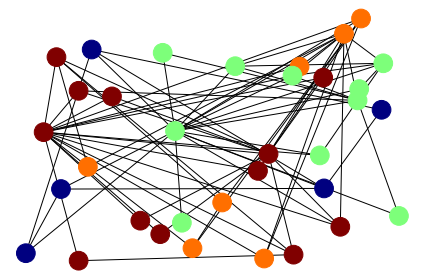

In [26]:
g = nx.from_numpy_matrix(adj)  # graph definition

fig, _ = plt.subplots(1)
nx.draw(g, pos=nx.random_layout(g), cmap=plt.get_cmap('jet'), node_color=np.log(one_hot_to_labels(labels_one_hot)),
        node_size=np.sum(200 * labels_one_hot, axis=-1) + 150)
plt.tight_layout()

Each node symbolizes one person in the social network. The edges indicate a close social relationship/connection. The colors indicate the group affiliation of each member. Better visualization of the graph can be done using **spring_layout**

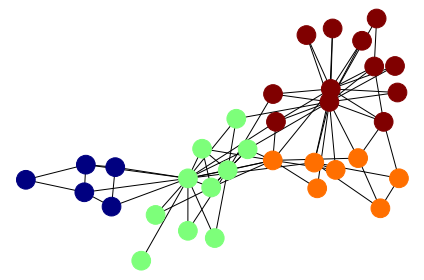

In [27]:
np.random.seed(2)
fig, _ = plt.subplots(1)
nx.draw(g, pos=nx.spring_layout(g), cmap=plt.get_cmap('jet'), node_color=np.log(one_hot_to_labels(labels_one_hot)),
        node_size= np.sum(200 * labels_one_hot, axis=-1) + 150)
plt.tight_layout()

### Preparing the data for training

For preparing the data for the semi-supervised task, we need to blind some of the data points by removing their labels. We assume that we only have information from 4 people, one from each group

In [28]:
np.random.seed(2)

labels_to_keep = np.array([np.random.choice(np.nonzero(labels_one_hot[:, c])[0]) for c in range(4)])
mask = np.zeros(shape=labels_one_hot.shape[0], dtype=np.bool)
mask[labels_to_keep] = ~mask[labels_to_keep]

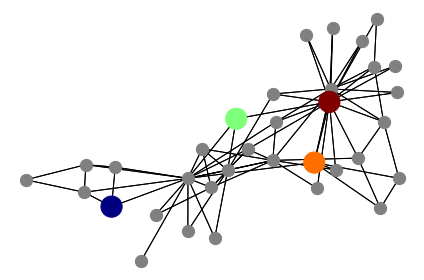

In [29]:
np.random.seed(2)
fig, axes = plt.subplots(1)
nx.draw(g, cmap=plt.get_cmap('jet'), node_color="grey",
        node_size=150)

np.seterr(divide = 'ignore') 
np.random.seed(2)
nx.draw(g, cmap=plt.get_cmap('jet'), node_color=np.log(one_hot_to_labels(labels_one_hot * mask[:,np.newaxis])),
        node_size=450, ax=axes)
np.seterr(divide = 'warn')
plt.tight_layout()

This data set (described by the above graph) can be used use for building a semi-supervised classification model using graph convolutional networks.

### Model definition

The main task is to create a Graph Convolutional Network (GCN) to classify the unlabeled nodes of the graph. An additional preliminary task is to create a mask to hide the labels of all nodes except the four ones when training the GCN

**Task 1**: Create appropriate training and validation sets by masking the labels

In [14]:
train_mask = np.zeros(shape=labels_one_hot.shape[0], dtype=np.bool)
train_mask[labels_to_keep] = ~train_mask[labels_to_keep]
val_mask = ~train_mask

print("val_mask:\n", val_mask)
print("\ntrain_mask:\n", train_mask)

val_mask:
 [ True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True False  True False]

train_mask:
 [False False False False  True False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False  True False  True]


In [15]:
# Preprocessing and preparing of data
y_train = labels_one_hot * train_mask[..., np.newaxis]
y_val = labels_one_hot * val_mask[..., np.newaxis]

fltr = spektral.layers.GCNConv.preprocess(adj).astype('f4')  # normalize the adjacency matrix
X = np.identity(34)  # create input for the DNN (the existence of each person (one-hot encoded))

**Task 2**: Construct a **Keras** model and add GCN layers using **spektral.layers.GCNConv()**. The adjacency matrix has to be passed to each GCN layer.

In [30]:
F = 4  # number of features
N = adj.shape[0]  # number of nodes

X_in = keras.layers.Input(shape=(N,))
fltr_in = keras.layers.Input(shape=(N,))
x = spektral.layers.GCNConv(F, activation='tanh', use_bias=False)([X_in, fltr_in])
x = keras.layers.Dropout(0.4)(x)
x = spektral.layers.GCNConv(F, activation='tanh', use_bias=False)([x, fltr_in])
x = keras.layers.Dropout(0.4)(x)
x = spektral.layers.GCNConv(F, activation='tanh', use_bias=False)([x, fltr_in])
x = keras.layers.Dropout(0.4)(x)
output = spektral.layers.GCNConv(4, activation='softmax', use_bias=False)([x, fltr_in])

model = keras.models.Model(inputs=[X_in, fltr_in], outputs=output)

print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
gcn_conv_4 (GCNConv)            (None, 4)            136         input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4)            0           gcn_conv_4[0][0]      

### Training of the GCN model

**Task 3**: Train the model, using of the skeletons below. You have to train the network on a single data structure (an undirected graph). Thus, the input data are always **[X, fltr]**, and the targets are labels_one_hot. Do not forget to mask the DNN predictions for nodes for which labels are not known. This will guarantee that only the labels made for the four nodes contribute to the objective. For implementing this condition to perform semi-supervised node classification, you can make use of the sample_weight argument of **model.train_on_batch()**.


In [31]:
learning_rate = 0.01
epochs = 2000

model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate, decay=1e-3),
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])

In [32]:
history = []

for i in range(epochs):
    loss, acc = model.train_on_batch([X, fltr], labels_one_hot,
                                     sample_weight=train_mask)

    val_loss, val_acc = model.test_on_batch([X, fltr], labels_one_hot, sample_weight=val_mask)
    history.append([val_loss, val_acc])

    if i % 100 == 0:
        print("iteration:", i, "val_loss:", val_loss, "val_accuracy:", val_acc)
        print("iteration:", i, "loss:", loss, "accuracy:", acc)

iteration: 0 val_loss: 1.2115939855575562 val_accuracy: 0.13333334028720856
iteration: 0 loss: 0.1607309728860855 accuracy: 0.25
iteration: 100 val_loss: 0.49499770998954773 val_accuracy: 0.8999999761581421
iteration: 100 loss: 0.08656303584575653 accuracy: 0.75
iteration: 200 val_loss: 0.23617015779018402 val_accuracy: 0.9333333373069763
iteration: 200 loss: 0.05209062248468399 accuracy: 0.75
iteration: 300 val_loss: 0.18831947445869446 val_accuracy: 0.8999999761581421
iteration: 300 loss: 0.06344947963953018 accuracy: 0.75
iteration: 400 val_loss: 0.152197003364563 val_accuracy: 0.8999999761581421
iteration: 400 loss: 0.05840900167822838 accuracy: 0.75
iteration: 500 val_loss: 0.13052548468112946 val_accuracy: 0.9333333373069763
iteration: 500 loss: 0.042411282658576965 accuracy: 0.75
iteration: 600 val_loss: 0.14921753108501434 val_accuracy: 0.9333333373069763
iteration: 600 loss: 0.02079726569354534 accuracy: 1.0
iteration: 700 val_loss: 0.12939126789569855 val_accuracy: 0.93333333

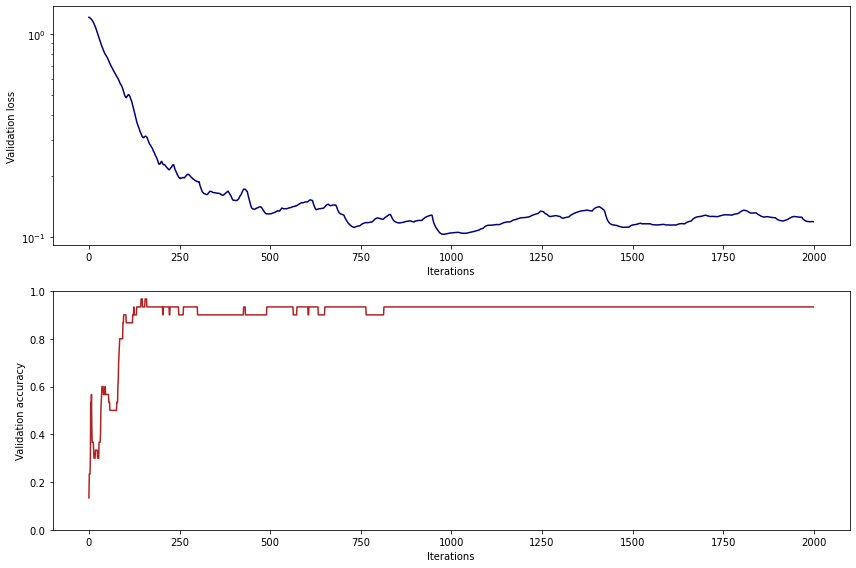

In [33]:
fig, axes = plt.subplots(2, figsize=(12,8))
if type(history) == dict:
    loss = history["val_loss"]
    acc = history["val_acc"]
else:
    loss, acc = np.split(np.array(history), 2, axis=-1)
x = np.arange(len(loss))
axes[0].plot(x, loss, c="navy")
axes[0].set_yscale("log")
axes[0].set_ylabel("Validation loss")
axes[1].plot(x, acc, c="firebrick")
axes[1].set_ylabel("Validation accuracy")
axes[1].set_ylim(0, 1)
axes[0].set_xlabel("Iterations")
axes[1].set_xlabel("Iterations")
plt.tight_layout()